In [14]:
import json
import psycopg2
import time
import pandas as pd
from datetime import datetime
import numpy as np
import math
import pickle
import warnings
import os
import pandas.io.sql as sqlio
# from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# conn = psycopg2.connect(
#   port='5432',
#   host= "shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com",
#   user= "softtouchlenses_4e0b7c925f8444429457581f35678aea",
#   password="softtouchlenses_4e0b7c925f8444429457581f35678aea_password",
#   database= "softtouchlenses_4e0b7c925f8444429457581f35678aea_db")
# conn = psycopg2.connect(
#   host='shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com',
#   port='5432',
#   user='paakhi_b014108f50994e35ab8fa4e2dc26d612',
#   password='paakhi_b014108f50994e35ab8fa4e2dc26d612_password',
#   database='paakhi_b014108f50994e35ab8fa4e2dc26d612_db')
conn = psycopg2.connect(
    host='shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com',
    port='5432',
    user='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c',
    password='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_password',
    database='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_db'
)

In [16]:
q=('''select created_at as order_date,
id as order_id,
total_price as order_amount,
customer_id as user_id
from orders
WHERE
cancelled_at is NULL;
''')

e=pd.read_sql(q,conn)
e = e[e['order_date'] >= '2023-01-01']
e = e[e['order_date'] <= '2023-12-31']
# e = e[e['order_date'] <= '2023-06-30']
e['order_date']=e['order_date'].dt.date
e['order_date']=pd.to_datetime(e['order_date'])
e['user_id']=e['user_id']
e['order_amount']=e['order_amount']

#Delta Columns
e['DeltaDaysinOrders']=(e.groupby('user_id').order_date.shift() - e.order_date).dt.days.abs()
e['DeltaOrderValues']=(e.groupby('user_id').order_amount.shift() - e.order_amount)

x1=e.groupby('user_id').agg(
        LastDate=pd.NamedAgg(column='order_date', aggfunc= 'max'),
        FirstDate=pd.NamedAgg(column='order_date', aggfunc='min'),
        Frequency=pd.NamedAgg(column='order_id', aggfunc='nunique'),
        AOV=pd.NamedAgg(column='order_amount', aggfunc='mean'),
        MeanDaysDelta=pd.NamedAgg(column='DeltaDaysinOrders', aggfunc='mean'),
        MeanOVDelta=pd.NamedAgg(column='DeltaOrderValues', aggfunc='mean'),
        SecondDate=pd.NamedAgg(column='order_date', aggfunc=lambda x: x.nsmallest(2).max()),
        TotalTransactions=pd.NamedAgg(column='order_id', aggfunc='nunique'),
        OrderValue=pd.NamedAgg(column='order_amount', aggfunc='sum'),
    ).reset_index()

globalmaxdate=e['order_date'].max()
x1['Recency']=globalmaxdate-x1['LastDate']
x1['Recency']=x1['Recency'].dt.days.abs()
x1['ActivatedQuater']=x1['FirstDate'].dt.to_period('Q')
x1['MaturityAge']=np.nan
x1.loc[x1['Frequency']>1,"MaturityAge"]=(x1['LastDate']-x1['FirstDate']).dt.days.abs()
x1['MeanDaysDelta']=x1['MeanDaysDelta'].fillna(0)
x1['MeanOVDelta']=x1['MeanOVDelta'].fillna(0)
# x1['FrequencyperDeltaDays']=x1['Frequency']/x1['MeanDaysDelta']

r_labels, f_labels,AOV_labels, m_labels,DelAOV_labels = range(4, 0, -1), range(1,5), range(1,5),range(1,5),range(1,5)
x1['r_score'] = x1['Recency'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = r_labels)).astype('int64')
x1['f2d_score'] = x1['Frequency'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = f_labels)).astype('int64')
x1['AOV_score'] = x1['AOV'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = AOV_labels)).astype('int64')
x1['m_score']=0
x1.loc[x1['MaturityAge'].notnull(),'m_score']= x1.loc[x1['MaturityAge'].notnull()]['MaturityAge'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = m_labels)).astype('int64')
x1['DelAOV'] = x1['MeanOVDelta'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = DelAOV_labels)).astype('int64')
x1['SumScore'] = x1['r_score'] + x1['f2d_score'] + x1['m_score'] + x1['AOV_score']+ x1['DelAOV']
def CohortLables_3(df):
  if ((df['Frequency']==1) & (df['r_score']>2)):
      return "New"
  elif ((df['Frequency'] == 1) & (df['r_score'] <= 2)):
      return 'Churned (Single Use Only)'
  elif ((df['Frequency'] > 1) & (df['m_score'] < 3) & (df['r_score'] >2)):
      return 'Recent & Loyals'
  elif ((df['Frequency'] > 1) & (df['m_score'] >=3) & (df['r_score'] > 2)):
      return 'Champions'
  else:
      return 'Churned (Repeat Use)'
# Create a new variable RFM_Level
x1['CohortLabel'] = x1.apply(CohortLables_3, axis=1)

C:\Users\CEPL\AppData\Local\Temp\ipykernel_11376\313861312.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  e=pd.read_sql(q,conn)


# COMPONENT-1

In [17]:
freq = x1.groupby("TotalTransactions").agg(
    Users = pd.NamedAgg(column = 'user_id', aggfunc = 'nunique')).reset_index()
freq["OrderVolume"] = freq["TotalTransactions"] * freq["Users"]
freq

,TotalTransactions,Users,OrderVolume
0,1,23408,23408
1,2,3329,6658
2,3,969,2907
3,4,368,1472
4,5,181,905
5,6,142,852
6,7,58,406
7,8,39,312
8,9,25,225
9,10,23,230


In [18]:
freq["Users"].sum()

28575

# COMPONENT-2

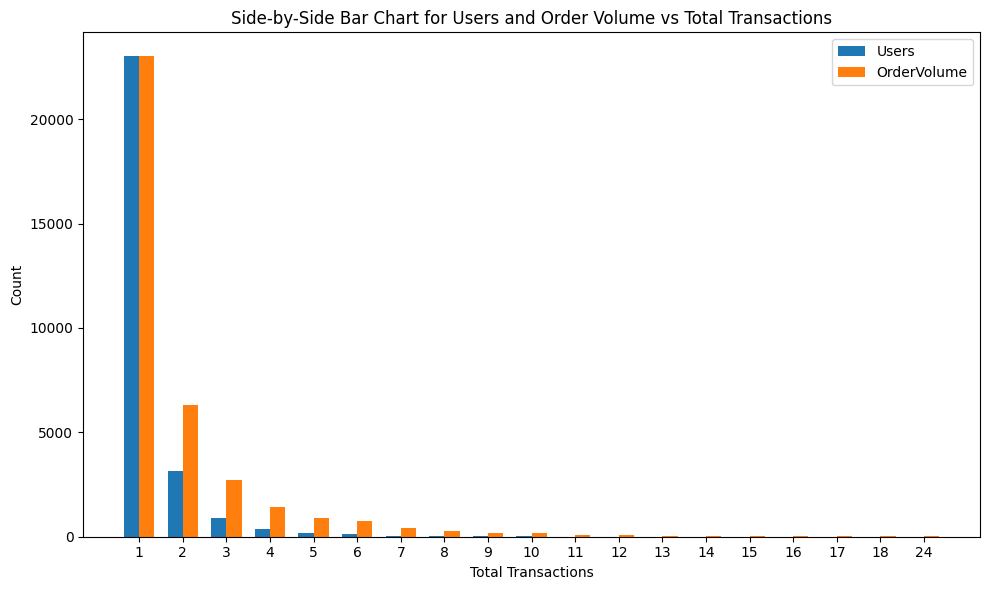

In [36]:
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(freq['TotalTransactions']))
bar1 = plt.bar(index, freq['Users'], bar_width, label='Users')
bar2 = plt.bar(index + bar_width, freq['OrderVolume'], bar_width, label='OrderVolume')
plt.xlabel('Total Transactions')
plt.ylabel('Count')
plt.title('Side-by-Side Bar Chart for Users and Order Volume vs Total Transactions')
plt.xticks(index + bar_width / 2, freq['TotalTransactions'])  # Positioning the x-axis labels in the middle of the two bars
plt.legend()
plt.tight_layout()
plt.show()